In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA
import matplotlib as mpl
import matplotlib.pyplot as plt

symbols = ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE',
           'BMW.DE', 'CBK.DE', 'CON.DE', 'DAI.DE', 'DB1.DE',
           'DBK.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE',
           'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LHA.DE',
           'LIN.DE', 'LXS.DE', 'MRK.DE', 'MUV2.DE', 'RWE.DE',
           'SAP.DE', 'SDF.DE', 'SIE.DE', 'TKA.DE', 'VOW3.DE',
           '^GDAXI']

data = pd.DataFrame()
h5 = pd.HDFStore('DAXCompAll.h5')
# start='2010-01-01', end='2015-12-31', Close Price
for sym in symbols:
    data[sym] = h5[sym]
h5.close()

dax = pd.DataFrame(data.pop('^GDAXI'))


(504, 30)


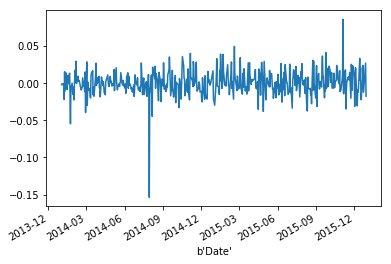

In [2]:
prices = data[1021:]
tags = ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE',
        'BMW.DE', 'CBK.DE', 'CON.DE', 'DAI.DE', 'DB1.DE',
        'DBK.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE',
        'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LHA.DE',
        'LIN.DE', 'LXS.DE', 'MRK.DE', 'MUV2.DE', 'RWE.DE',
        'SAP.DE', 'SDF.DE', 'SIE.DE', 'TKA.DE', 'VOW3.DE']

returns = pd.DataFrame()
logret = pd.DataFrame()
for sym in tags:
	returns[sym] = np.diff(prices[sym])/prices[sym][:-1]
	logret[sym] = np.diff( np.log(prices[sym]) )
	
returns["ADS.DE"].plot();
print(returns.shape)

In [3]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint
from scipy import stats


In [4]:
returns
N_PRIN_COMPONENTS = 10
pca = PCA(n_components=N_PRIN_COMPONENTS)


In [5]:
pca.fit(returns)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
returns_pca = pca.transform(returns)

In [8]:
returns.shape

(504, 30)

In [9]:
returns_pca.shape

(504, 10)

In [10]:
pca.components_.shape

(10, 30)

In [11]:
pca.components_.T.shape

(30, 10)

In [12]:
X = pca.components_.T

In [13]:
clf = DBSCAN(eps=1.9, min_samples=3)
print(clf)


DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=1, p=None)


In [14]:
X = preprocessing.StandardScaler().fit_transform(X)
print(X.shape)

(30, 10)


In [15]:
clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: ", n_clusters_)



Clusters discovered:  1


In [16]:
clustered = clf.labels_

In [17]:
clustered

array([ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0, -1,  0, -1,  0,
        0, -1, -1,  0, -1, -1,  0, -1,  0, -1,  0, -1, -1], dtype=int64)

In [18]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print("Total pairs possible in universe: ", (ticker_count*(ticker_count-1)/2))

Total pairs possible in universe:  435.0


In [19]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())

In [20]:
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())

In [21]:
clustered_series = clustered_series[clustered_series != -1]

In [23]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print("Clusters formed: ", len(ticker_count_reduced))
print("Pairs to evaluate: ", (ticker_count_reduced*(ticker_count_reduced-1)).sum())


Clusters formed:  1
Pairs to evaluate:  306


In [24]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

(0.0, 1.0, 0.0, 1.0)

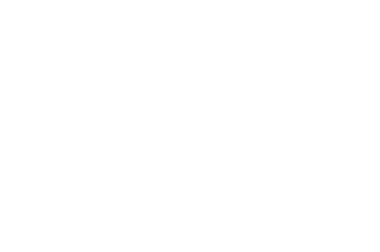

In [27]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')


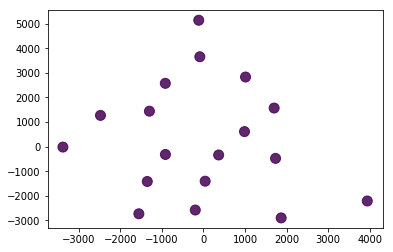

In [31]:
plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1]
    #,cmap=cm.Paired
)

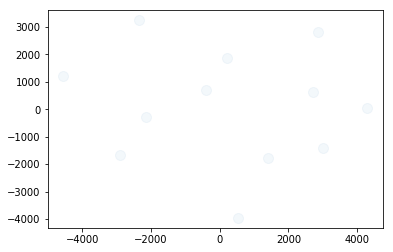

In [32]:
plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

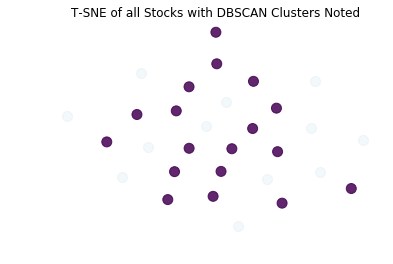

In [33]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1]
    #,cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');


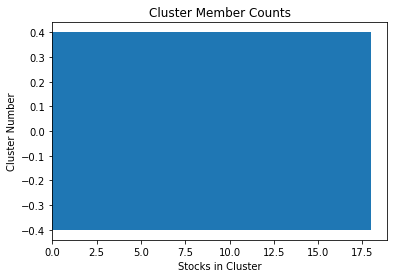

In [35]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

In [36]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]


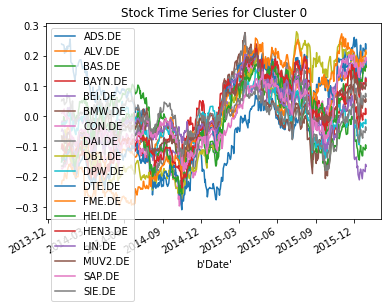

In [38]:
# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(prices[tickers].mean())
    data = np.log(prices[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)


In [39]:
which_cluster = clustered_series.loc[symbols('JPM')]
clustered_series[clustered_series == which_cluster]

TypeError: 'list' object is not callable